In [ ]:
!pip install numdifftools
import numdifftools as ndt

     |████████████████████████████████| 962kB 8.3MB/s 


In [ ]:
import numpy as np
import pandas as pd
import statistics as st
import math
#import random.

In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/Assignment1_ELL409/Q1/health_data.csv" #replace with directory where data is stored 

Mounted at /content/drive


In [ ]:
datafrm = pd.read_csv(drive_path)

def confusion_matrx(out_true_dict,num_class):
  conf_m = np.zeros(dtype=int,shape=(num_class,num_class))
  
  for i in out_true_dict.keys():
    true_v = i
    pred_vs = out_true_dict[i]
    for pred_v in pred_vs:
      conf_m[true_v][pred_v] +=1

  return conf_m

def accuracy(out_dict,num_class):
  acc = 0
  conf_m = confusion_matrx(out_dict,num_class)
  for i in range(num_class):
    acc += conf_m[i][i]
  acc = acc/sum(sum(conf_m))
  return acc

def precis_recall_f(out_dict,num_class):
  '''only for binary'''
  cfm = confusion_matrx(out_dict,num_class)
  precision = (1/(cfm[1][1] + cfm[0][1]))*cfm[1][1]
  recall = (1/(cfm[0][0] + cfm[1][0]))*cfm[0][0]
  fscore = 2*precision*recall*(1/(precision+recall))
  return precision,recall,fscore

#https://www.cs.cmu.edu/~tom/10601_sp08/slides/recitation-mle-nb.pdf
#http://www.ccs.neu.edu/home/alina/classes/Fall2018/Lecture7.pdf

In [ ]:
#Preprocessing
#https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas

def split_data(data, r,flag): 
    '''r: ratio of split, r indicates amount in train; flag indicates if random or linear split'''
    train_len = int(len(data) * r) 
    test_len = len(data) - train_len
    test = [] 
    train = []

    if(flag==0):
      indxs = np.random.rand(len(data)) < r
      train = data[indxs]
      test = data[~indxs]
    else:
      train = data
      while len(test) < test_len:
        inx = 0
        test.append(train.pop(inx))

    return np.asarray(train), np.asarray(test) 

def key_feat_map(data_arr):
  dict1 = {}
  for lst in data_arr:
    k = lst[-1]
    if k in dict1.keys():
      dict1[k].append(lst[:-1])
    else:
      dict1[k] = [np.asarray(lst[:-1])]
  for k in dict1:
    dict1[k] = np.asarray(dict1[k])
    #print(dict1[k].shape)
  return dict1

In [ ]:
#traindf,testdf = split_data(datafrm,0.7,1)
allv = datafrm.values.tolist()
allv_dict = key_feat_map(allv)

traindict = {0:[],1:[]}
testdict = {0:[],1:[]}

#change 1 to 0 for random split
#kept linear split for uniformity with partner
traind,testd = split_data(list(allv_dict[0]),0.7,1)
traindict[0] = traind
testdict[0] = testd

traind,testd = split_data(list(allv_dict[1]),0.7,1)
traindict[1] = traind
testdict[1] = testd

In [ ]:
#make normalized dataset (it helps to have all training data within a certain range for EM)
#train = x_train - x_min / x_max - x_min [where the max,min arrays are feature wise max min]
#test = similar to train, but min and max are of the train dataset

traindict_std = traindict
testdict_std = testdict
for key in traindict.keys():
  #print(type(traindict[key]))
  #break
  lst = traindict[key]
  max_l = np.asarray([max(lst[:,j]) for j in range(len(lst[0]))])
  min_l = np.asarray([min(lst[:,j]) for j in range(len(lst[0]))])
  max_l = max_l - min_l
  for t in range(len(max_l)):
    if(t==0):
      t = 10**-5
  vals = []
  for feat in lst:
    tmp = feat - min_l
    tmp = np.divide(tmp,max_l)
    vals.append(tmp)

  traindict_std[key] = np.asarray(vals) 
  
  vals = []
  lst = testdict[key]
  for feat in lst:
    tmp = feat - min_l
    tmp = np.divide(tmp,max_l)
    vals.append(tmp)
  testdict_std[key] = np.asarray(vals)

Estimating density using Max. Likelihood Estimation.
Bayes Classifier, class conditional density Gaussian.

---



In [ ]:
def MLE_Gaussian_Params(data_lst):
  #MLE parameters obtained via closed form expression
  n = data_lst.shape[0] #number of data points
  k = data_lst.shape[1] #feature vector dimension
  mu = data_lst[0][:]
  for j in range(1,n):
    mu = mu + data_lst[j][:]
  mu = mu/n
  
  sd = np.zeros(shape=(k,k),dtype=float)
  #print(k)
  for j in range(n):
    tmp = data_lst[j][:] - mu
    #print(np.transpose(tmp[np.newaxis]).shape)
    sd += np.matmul(np.transpose(tmp[np.newaxis]),tmp[np.newaxis])
  
  sd = sd/n
  
  return mu,sd

def PDF_normaldistr(inpt,mu,sd):
  #mu = lst[0]
  #sd = lst[1]
  #print("in pdf")
  tmp = inpt-mu
  tmp = tmp[np.newaxis]
  k = tmp.shape[1]
  dt = np.linalg.det(sd)
  if(dt!=0):
    #print("det nonzero")    
    sdi = np.linalg.inv(sd)
    expt = np.matmul(tmp,sdi)
    expt = np.matmul(expt,np.transpose(tmp))*(-0.5)
    expt = math.exp(expt[0][0])
    #print("---")
    #print(expt)
    #print(((2*math.pi)**(-0.5*k))*((dt)**(-0.5)))
    #print("---")
    return expt*((2*math.pi)**(-0.5*k))*((dt)**(-0.5))
  
  else:
    print("0 det")
    #add gaussian noise when determinant of covariance 0
    sd1 = sd + np.random.normal(0,0.1,size=sd.shape)
    sdi = np.linalg.inv(sd1)
    dt = np.linalg.det(sd1)
    expt = np.matmul(tmp,sdi)
    expt = np.matmul(expt,np.transpose(tmp))*(-0.5)
    expt = math.exp(expt[0][0])
    return expt*((2*math.pi)**(-0.5*k))*((dt)**(-0.5))


def predict_label_MLEGauss(lst,lst_params,prior_arr):

  out_lab = (-1,0)

  for indx in range(len(lst_params)):
    theta = lst_params[indx]
    fx_y = prior_arr[indx]
    fx_y = fx_y*PDF_normaldistr(lst,theta[0],theta[1])
    
    #print(fx_y)
    if(out_lab[0]==-1):
      out_lab = (fx_y,indx)

    else:
      if(out_lab[0]<fx_y):
        out_lab = (fx_y,indx)

  return out_lab[1]

def Classify_MLE_Gauss(train_data_dict,test_data_dict,prior_arr):
  lst_params = []
  #true_class = []
  for k in train_data_dict.keys():
    lst_d = train_data_dict[k]
    mu,sd = MLE_Gaussian_Params(lst_d)
    lst_params.append((mu,sd))
    #true_class.append(k)
  
  #print(lst_params)
  
  dict_true_out = {}
  for ky in test_data_dict.keys():
    lst_d = test_data_dict[ky]
    out_list = []
    for arr in lst_d:
      out_l = predict_label_MLEGauss(arr,lst_params,prior_arr)
      out_list.append(out_l)
    
    dict_true_out[ky] = out_list
    
  return lst_params,dict_true_out

def findLabs_gauss(test_data_dict,lst_params,prior_arr):
  dict_true_out = {}
  for ky in test_data_dict.keys():
    lst_d = test_data_dict[ky]
    out_list = []
    for arr in lst_d:
      out_l = predict_label_MLEGauss(arr,lst_params,prior_arr)
      out_list.append(out_l)
    
    dict_true_out[ky] = out_list
  
  return dict_true_out

In [ ]:
#codeblock to save img to drive
#titl = 'Binary classification, Bayes rule, f(x|y) ~ multivariate normal'
#saves = "/content/drive/MyDrive/Assignment1_ELL409/Q1/BayesMultiGauss_ROC.png"
#plot_roc(traindict,testdict,titl,saves)

In [ ]:
import matplotlib.pyplot as plt

def get_roc_vals_gauss(traindict,testdict,num_pts=100):
  tpr = []
  fpr = []
  train_acc = []
  test_acc = []
  #lst = range(0,1,0.1)
  prior_arr = [len(traindict[0])/(len(traindict[0])+len(traindict[1])),0]
  prior_arr[1] = 1-prior_arr[0]
  params,output = Classify_MLE_Gauss(traindict,testdict,prior_arr)

  cm = confusion_matrx(output,2)
  #print(cm)
  mle_pt = [[cm[1][0]/(cm[1][0]+cm[1][1])],[cm[0][0]/(cm[0][0]+cm[0][1])]]
  output1 = findLabs_gauss(traindict,params,prior_arr)
  mle_acc = [accuracy(output,2),accuracy(output1,2),cm]
  del(output)
  del(output1)

  for i in np.linspace(0,1,num_pts,endpoint=False):
    prior_arr = [i,1-i]
    print(prior_arr)
    output = findLabs_gauss(testdict,params,prior_arr)  
    #
    #print(output)
    cm = confusion_matrx(output,2)
    #print(precis_recall_f(output,2))
    tpr.append(cm[0][0]/(cm[0][0]+cm[0][1]))
    fpr.append(cm[1][0]/(cm[1][0]+cm[1][1]))
    test_acc.append(accuracy(output,2))
    output = findLabs_gauss(traindict,params,prior_arr)  
    train_acc.append(accuracy(output,2))

  return tpr,fpr,mle_pt,train_acc,test_acc,mle_acc

def plt_roc(tpr,fpr,mle_pt,title_str,save_str):
  fig,ax = plt.subplots()
  plt.scatter(fpr,tpr,marker=".")
  plt.plot([0,1],[0,1],'--',c='r')
  plt.plot([mle_pt[0]],[mle_pt[1]],'v',c='m')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(title_str)
  plt.savefig(save_str)
  plt.show()
  plt.clf()
  return 0

def plt_tstr_acc(testacc,trainacc,mle_pt,xax,xtitle,titlestr,savestr):
  fig,ax = plt.subplots()
  plt.scatter(xax,testacc,marker=".",label="test")
  plt.scatter(xax,trainacc,marker="v",label="train")
  ax.legend()
  #plt.plot([0,1],[0,1],'--',c='r')
  #plt.plot([mle_pt[0]],,'o',c='m')
  #plt.plot([mle_pt[1]],,'o',c='k')
  plt.ylabel('Accuracies')
  plt.xlabel(xtitle)
  plt.title(titlestr)
  plt.savefig(savestr)
  plt.show()
  plt.clf()
  return 0

In [ ]:
tp,fp,mlp,tracc,tsacc,mlacc=get_roc_vals_gauss(traindict,testdict)

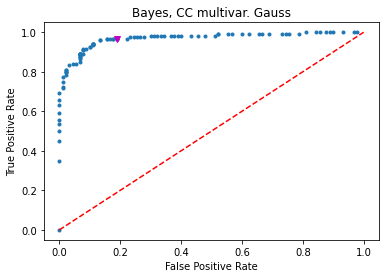

0

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_roc(tp,fp,mlp,"Bayes, CC multivar. Gauss","/content/drive/MyDrive/Assignment1_ELL409/Q1/BayesMultiGauss_ROC2.png")

In [ ]:
print(mlp)
print(mlacc)

[[0.18888888888888888], [0.9666666666666667]]
[0.9, 0.8346938775510204, array([[116,   4],
       [ 17,  73]])]


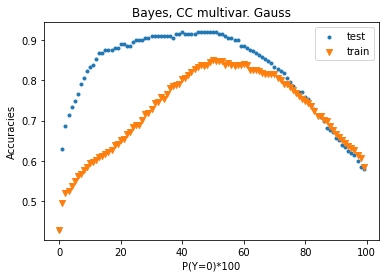

0

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_tstr_acc(tsacc,tracc,mlacc,list(range(len(tsacc))),"P(Y=0)*100","Bayes, CC multivar. Gauss","/content/drive/MyDrive/Assignment1_ELL409/Q1/BayesMultiGauss_BiasVar1.png")

In [ ]:
#Bias Variance

for j in range(0,4):

  testd,traind = split_data(datafrm,0.6,0)
  testdict1 = key_feat_map(testd)
  traindict1 = key_feat_map(traind)
  trainacc = []
  testacc = []
  k=20
  xvals = np.zeros(shape=k-1)
  numc = 2

  for i in range(1,k):
    frac = float(i)/(k-1)
    train1 = {}
    test1 = {}
    for key in traindict1.keys():
      lst = traindict1[key]
      train1[key] = lst[:int(frac*len(lst))]
      xvals[i-1] += int(frac*len(lst))
      lst = testdict1[key]
      test1[key] = lst[:int(frac*len(lst))]
      del(lst)
    
    priors = [len(train1[0])/(len(train1[0])+len(train1[1])),0]
    priors[1] = 1-priors[0]
    params,outp = Classify_MLE_Gauss(train1,test1,priors)
    testacc.append(accuracy(outp,numc))
    outp = findLabs_gauss(train1,params,priors)
    trainacc.append(accuracy(outp,numc))
  plt_tstr_acc(testacc,trainacc,0,xvals,"num. pt in train data","Bayes,  multivar. Gauss","/content/drive/MyDrive/Assignment1_ELL409/Q1/BayesMultiGauss_BiasVar_64" + str(j) + ".png")


In [ ]:
#plot Bias-Variance curves
#plot confusion mosaic

Bayes Classifier, class conditional density: Gaussian Mixture Model

In [ ]:
def PDF_normaldistr1(inpt,mu,sd):
  
  tmp = inpt-mu
  #print(type(sd))
  #print(mu)
  #print(sd)
  #if(len(sd)==1):
    #print("in")
  #try block to see if std deviation arr or int, to make code work for Naive bayes too
  try:
    k = len(sd)
  except:
    return pdf_uniGauss(inpt,[mu,sd])

  tmp = tmp[np.newaxis]
  k = tmp.shape[1]
  dt,val = np.linalg.slogdet(sd)
  
  if(dt!=0):
    #print("det nonzero")    
    dt = np.linalg.det(sd)
    sdi = np.linalg.inv(sd)
    expt = np.matmul(tmp,sdi)
    expt = np.matmul(expt,np.transpose(tmp))*(-0.5)
    expt = math.exp(expt[0][0])
 #   print("---")
   # print(expt)
  #  print(((2*math.pi)**(-0.5*k))*((dt)**(-0.5)))
   # print("---")
    return expt*((2*math.pi)**(-0.5*k))*((dt)**(-0.5))
  
  else:
    print("0 det")
    sd1 = sd + np.random.normal(0,0.1,size=sd.shape)
    return PDF_normaldistr1(inpt,mu,sd1)


In [ ]:
#EM FOR GMMs, (coeff*multivariate gaussian)

def latent_probs(num_data,data,gmm_coeffs,gmm_mu,gmm_sd):
  gamma_wts = np.zeros(shape=(num_data,len(gmm_coeffs)))
  #normal_distrn = [,pdf_uniGauss]
  #all_j_sums = []
  for i in range(num_data):
    temp_sum = 0
    for j in range(len(gmm_coeffs)):
      
      val = PDF_normaldistr1(data[i],gmm_mu[j],gmm_sd[j])
    #  print(val)
    #  print(data[i])
    #  print(gmm_mu[j])
    #  print(gmm_sd[j])
      gamma_wts[i][j] = val*gmm_coeffs[j]
     # print("val is: " + str(val))
      #print("coeff is: " + str(gmm_coeffs[j]))
      temp_sum += val*gmm_coeffs[j]
      #all_j_sums.append(temp_sum)
      #print(temp_sum)
    gamma_wts[i,:] = gamma_wts[i,:]/temp_sum

  return gamma_wts 

def find_maximized(data,gamma_wts):
  gmm_mu = []
  gmm_coeffs = []
  gmm_sd = []
  n = gamma_wts.shape[0]
  #print(gamma_wts.shape)
  for k in range(gamma_wts.shape[1]):
    pi_k = (1/n)*(np.sum(gamma_wts[:,k]))
    try:
      mu_k = np.zeros(shape=len(data[0]))
      for i in range(n):
        mu_k += [gamma_wts[i][k]*t for t in data[i]] ##might give bt with data[i] not iterable
      mu_k = mu_k/(n*pi_k)
    
      sd_k = np.zeros(shape=(len(data[0]),len(data[0])))
      for j in range(n):
        tmp = data[j] - mu_k
        sd_k += np.multiply(np.matmul(np.transpose(tmp[np.newaxis]),tmp[np.newaxis]),gamma_wts[j][k])  
      sd_k = sd_k/(n*pi_k)
    
    except:
      mu_k = np.zeros(shape=1)
      for i in range(n):
        mu_k += gamma_wts[i][k]*data[i]
      mu_k = mu_k/(n*pi_k)

      sd_k = np.zeros(shape=(1,))
      for j in range(n):
        tmp = np.asarray([data[j]]) - mu_k
        sd_k += np.multiply(np.matmul(np.transpose(tmp[np.newaxis]),tmp[np.newaxis]),gamma_wts[j][k])[0]  
      sd_k = sd_k/(n*pi_k)
    
    gmm_coeffs.append(pi_k)
    gmm_mu.append(mu_k)
    gmm_sd.append(sd_k)

  return gmm_coeffs,gmm_mu,gmm_sd

def logLikeli_EMM(data,gmm_coeffs,gmm_mu,gmm_sd,gamma_coeffs):
  logl = 0
  for i in range(len(data)):
    for j in range(len(gmm_coeffs)):
     #pdf_normval = 0 
      #try: 
      pdf_normval = PDF_normaldistr1(data[i],gmm_mu[j],gmm_sd[j])
      #except:
       # new_sd = gmm_sd[j] + np.random.normal(0,1,shape=gmm_sd[j].shape)
        #pdf_normval = PDF_normaldistr(data[i],gmm_mu[j],new_sd)
      #finally:
      ep = 0
      #print(gmm_coeffs[j])
      #print(pdf_normval)
      v1 = abs(gmm_coeffs[j]*pdf_normval)
      if(v1==0):
        ep = 10**-3
        print(ep)  
      val = math.log(v1+ep)
      val = val*gamma_coeffs[i][j]

      logl+=val
  return logl
  #print("bpp")

def EM_GMMs(n,data_lst,init_coeff,init_mu,init_sd,tolr=10^-3,maxiter=100):
  stopCon=False
  
  init_logL,temp_logL = 0,0

  iter = 0
  if(len(init_coeff)>4):
    maxiter = 450
  while(stopCon==False):
    print("iter is: " + str(iter))
    init_gm_wts = latent_probs(n,data_lst,init_coeff,init_mu,init_sd)
    gmmc,gmmm,gmmsd = find_maximized(data_lst,init_gm_wts)
    print(init_gm_wts)
    print([gmmc,gmmm,gmmsd])
    #init_gm_wts = latent_probs(n,data_lst,gmmc,gmmm,gmmsd)
    #init_logL = temp_logL
    #temp_logL = logLikeli_EMM(data_lst,gmmc,gmmm,gmmsd,init_gm_wts)

    iter+=1
    #if(abs(init_logL-temp_logL)<tolr and iter>1):
    #if(iter>150):
    #if(abs(init_logL-temp_logL)<tolr or iter>maxiter):
    if(iter>maxiter):
      stopCon = True
      print(iter)
      print(abs(init_logL-temp_logL))
  print("bpp")
  return gmmc,gmmm,gmmsd

#https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

def pdf_GMM(inpt,params):
  gmm_c,gmm_m,gmm_sd = params[0],params[1],params[2]
  val = 0
  for t in range(len(gmm_c)):
    val += gmm_c[t]*PDF_normaldistr(inpt,gmm_m[t],gmm_sd[t])
  return val

def MLE_predictLab_GMM(inpt,params_arr,prior_arr):
  #all_vals = []
  max_val = (-1,0)
  for key in params_arr.keys():
    params = params_arr[key]
    val = prior_arr[key]
    val = val*pdf_GMM(inpt,params)

    if(max_val[0]==-1):
      max_val = (val,key)
    else:
      if(max_val[0]<val):
        max_val = (val,key)

  #print("boo") 
  return max_val[1] 

def find_params_traindict(train_dict,init_guess):
  params_dict = {}
  for k in train_dict.keys():
      c,mu,sd = EM_GMMs(len(train_dict[k]),train_dict[k],init_guess[0],init_guess[1],init_guess[2])
      params_dict[k] = (c,mu,sd)
  return params_dict

def tested_labs(test_dict,params_dict,prior_arr):
  tested_labels = {}
  for k in test_dict.keys():
    feats = test_dict[k]
    out_labs = []
    for feat in feats:
      labl = MLE_predictLab_GMM(feat,params_dict,prior_arr)
      out_labs.append(labl)
    tested_labels[k] = out_labs
  return tested_labels

def MLE_Bayes_GMM(train_dict,test_dict,init_guess,vary_pri,prior_arr1=[0.5,0.5],num_pts=100):
  params_dict = find_params_traindict(train_dict,init_guess)
  
  if(vary_pri==1):
      for i in np.linspace(0,1,num_pts,endpoint=False):
        prior_arr = [i,1-i]
     #   print(prior_arr)
        output = tested_labs(test_dict,params_dict,prior_arr)
        #print(output)
        cm = confusion_matrx(output,2)
        #print(precis_recall_f(output,2))
        tpr.append(cm[0][0]/(cm[0][0]+cm[0][1]))
        fpr.append(cm[1][0]/(cm[1][0]+cm[1][1]))

      prior_arr = [len(train_dict[0])/(len(train_dict[0])+len(train_dict[1])),0]
      prior_arr[1] = 1-prior_arr[0]
      output = tested_labs(test_dict,params_dict,prior_arr)
      #print(output)
      cm = confusion_matrx(output,2)
      mle_pt = [[cm[1][0]/(cm[1][0]+cm[1][1])],[cm[0][0]/(cm[0][0]+cm[0][1])]]
      return tpr,fpr,mle_pt
  
  else:
    prior_arr1[0] = len(train_dict[0])/(len(train_dict[0])+len(train_dict[1]))
    prior_arr1[1] = 1-prior_arr1[0]
    tested_labels = tested_labs(test_dict,params_dict,prior_arr1)
    test_acc = accuracy(tested_labels,2)
    
    train_labels = tested_labs(train_dict,params_dict,prior_arr1)
    train_acc = accuracy(train_labels,2)
    
    return test_acc,train_acc

In [ ]:
def randomList(m,coeff):  
    arr = np.zeros(shape=m)  
    while(sum(arr)!=1):
        arr[np.random.randint(0, m)] += coeff;  
     #   print(arr)
    max = 0
    for t in range(m):
      arr[t] = round(arr[t],2)

      if(arr[t]>arr[max]):
        max = t
      if(arr[t]==0):
        arr[t] = coeff
        arr[max] = arr[max] - coeff

    return arr
#print(randomList(5))  

def generate_random_initguess(num_comps,num_feat,coeff,ub):
  gmm_coeffs = [1/num_comps for t in range(num_comps)]
  if(num_feat==1):
    gmm_mu = [np.random.rand(1) for i in range(num_comps)]
    gmm_sd = [np.random.randint(1,4)*0.25 for i in range(num_comps)]
    return {0:gmm_coeffs,1:gmm_mu,2:gmm_sd}
  
  gmm_mu = [np.random.rand(num_feat)*10 for i in range(num_comps)]
  gmm_sd_t = [np.random.randint(0,ub,size=(num_feat,num_feat)) for i in range(num_comps)]
  gmm_sd = [np.matmul(np.transpose(tmp),tmp) for tmp in gmm_sd_t]

  return {0:gmm_coeffs,1:gmm_mu,2:gmm_sd}

In [ ]:
#num_comps = 5
num_feat = 3
train_accs = []
test_accs = []
for num_comps in [5]:
  initg = generate_random_initguess(num_comps,num_feat,0.1,100)
  test_acc,train_acc = MLE_Bayes_GMM(traindict,testdict,initg,0)
  print(test_acc)
  print(train_acc)
  train_accs.append(train_acc)
  test_accs.append(test_acc)

In [ ]:
print(test_accs)
print(train_accs)

[0.9857142857142858]
[0.7959183673469388]


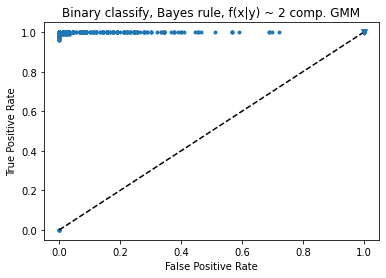

0

In [ ]:
plt_roc(tpr,fpr,mlept,'Binary classify, Bayes rule, f(x|y) ~ GMM',"/content/drive/MyDrive/Assignment1_ELL409/Q1/BayesGMM_4Comp_ROC.png")

In [ ]:
print(confusion_matrx(out,2))

[[120   0]
 [ 90   0]]


Experiments with Naive Bayes

In [ ]:
#print(traindict[0][:,1])
#params = MLE_uniGMM(traindict[0][1:100,0])a
#print(pdf_uniGMM(traindict[0][101,0],params))

In [ ]:
#MLE for Naive Bayes || 

def MLE_uniGMM(data):
  num_comps = 2
  init_guess = generate_random_initguess(num_comps,1,0.1,20)
  print(init_guess)
  c,mu,sd = EM_GMMs(len(data),data,init_guess[0],init_guess[1],init_guess[2])
  print(c)
  print(mu)
  print(sd)
  return [c,mu,sd]

def pdf_uniGMM(inpt,params):
  gmm_c,gmm_m,gmm_sd = params[0],params[1],params[2]
  val = 0
  for t in range(len(gmm_c)):
    val += gmm_c[t]*pdf_uniGauss(inpt,[gmm_m[t],gmm_sd[t]])
  return val

def MLE_uniGauss(data):
  #data has to be single feature ka array
  mu = np.sum(data)
  mu = mu/data.shape[0]
  print(mu)
  #print(data)
  #tmp = [(t - mu)**2 for t in data]
  tmp = 0
  for t in data:
    tmp += (t-mu)**2
  sd = (1/(data.shape[0]))*(tmp)
  return [mu,math.sqrt(sd)]

def pdf_uniGauss(x,lst):
  mu = lst[0]
  sd = lst[1]
  if(sd==0):
    sd = 10**-4
  expt = (-0.5)*(x-mu)*(x-mu)*(1/sd)
  return (1/sd)*(0.5)*(1/(math.pi))*math.exp(expt)

def MLE_uniExp(data):
  #data has to be single feature ka array
  #would need to be modified to Laplacian agar neg features possible
  mu = np.sum(data)
  mu = mu/data.shape[0]
  return [mu]

def pdf_uniExp(x,mu1):
  mu = mu1[0]
  return (1/mu)*(math.exp(-x/mu))

def MLE_uniUnf(data):
  #data has to be single feature ka array
  return [np.amax(data)]

def pdf_uniUnf(x,mu):
  return 1/mu[0]

def MLE_predictLab_Naive(test,params_arr,fn_arr,priors):
  #all_vals = []
  max_val = (-1,0)
  #print(params_arr.keys())
  
  for key in params_arr.keys():
   #print(key)
    params = params_arr[key]
    val = 1
    
    for i in range(len(test)):
      pxi_y = fn_arr[i](test[i],params[i])
      val = val*pxi_y
    
    py = priors[key] #equiprobable for now
    val = val*py

    if(max_val[0]==-1):
      max_val = (val,key)
    else:
      if(max_val[0]<val):
        max_val = (val,key)

  #print("boo") 
  return max_val[1] 

def labels_MLE_naiveB(test_dict1,params_arr,fn_arr,priors):
  dict_true_out = {}
  for k in test_dict1.keys():
    lst_feats = test_dict1[k]
    out_labels = []

    for feat in lst_feats:
      lbl = MLE_predictLab_Naive(feat,params_arr,fn_arr,priors)
      out_labels.append(lbl)

    dict_true_out[k] = out_labels
  
  return dict_true_out

def MLE_classify_Naive(train_dict,test_dict,MLE_arr,fn_arr,is_iid,priors,flag_roc=1,num_pts=100):
  
  #training
  params_arr = {}
  
  for key1 in train_dict.keys():
    lst_d = train_dict[key1]
    len_feat = len(lst_d[0])
    feat_params = []
    
    if(is_iid==1):
      for i in range(len_feat):
        xi = lst_d[:,i]
       # print(xi)
        feat_params.append(MLE_arr[i](xi))
      #print(feat_params)
    
    else:
      #build dict
      feat_params = [0 for t in range(len_feat)]
      #print(len_feat)
      MLE_dict = {}
      for i in range(len(MLE_arr)):
        key = MLE_arr[i]
        print(key)
        if key in MLE_dict.keys():
          MLE_dict[key].append(i)
        else:
          MLE_dict[key] = [i]
      
      for fn in MLE_dict.keys():
        
        feats = MLE_dict[fn]
        #print(feats)
        data_all = lst_d[:,feats[0]]
        #print(feats)
        for j in range(1,len(feats)):
          np.append(data_all,lst_d[:,feats[j]])
    
        lst_params = fn(data_all)
        
        for t in feats:
          feat_params[t] = lst_params
      
      #print("fin els")
    #print(feat_params)
    #print(MLE_dict.keys())
    
    params_arr[key1] = feat_params  

    #testing
  if(flag_roc==1):
    tpr = []
    fpr = []
    test_acc = []
    train_acc = []
    
    for i in np.linspace(0,1,num_pts,endpoint=False):
      prior_arr = [i,1-i]
      output = labels_MLE_naiveB(test_dict,params_arr,fn_arr,prior_arr)
      cm = confusion_matrx(output,2)
      denom_t = cm[0][0]+cm[0][1]
      if(denom_t==0):
        print(cm)
        print(prior_arr)
        denom_t = 10**-4
      tpr.append(cm[0][0]/denom_t)
      denom_t = cm[1][0]+cm[1][1]
      if(denom_t==0):
        print(cm)
        denom_t = 10**-4
      fpr.append(cm[1][0]/denom_t)
      
      test_acc.append(accuracy(output,2))
      output = labels_MLE_naiveB(train_dict,params_arr,fn_arr,prior_arr)
      train_acc.append(accuracy(output,2))
      del(output)

    prior_arr = [len(train_dict[0])/(len(train_dict[0])+len(train_dict[1])),0]
    prior_arr[1] = 1-prior_arr[0]
    output = labels_MLE_naiveB(test_dict,params_arr,fn_arr,prior_arr)
    cm = confusion_matrx(output,2)
    mle_pt = [[cm[1][0]/(cm[1][0]+cm[1][1])],[cm[0][0]/(cm[0][0]+cm[0][1])]]
    
    output1 = labels_MLE_naiveB(train_dict,params_arr,fn_arr,prior_arr)
    mle_acc = [accuracy(output,2),accuracy(output1,2)]
    del(output)
    del(output1)
    print("---")
    print(tpr)
    print(fpr)
    print(mle_acc)
    print("----")
    return tpr,fpr,mle_pt,test_acc,train_acc,mle_acc
  
  else:
    print("eh")



In [ ]:
num_feats = len(traindict_std[0][1])
MLE_all = [MLE_uniGauss,MLE_uniExp,MLE_uniUnf,MLE_uniGMM]
fn_all = [pdf_uniGauss,pdf_uniExp,pdf_uniUnf,pdf_uniGMM]

In [ ]:
print(len(traindict[0]))
print(len(traindict[1]))
print(len(testdict[0]))
print(len(testdict[1]))

In [ ]:
i1 = 0; i2 = 3; i3 = 0;
MLE_arr = [MLE_all[i1],MLE_all[i2],MLE_all[i3]]
fn_arr = [fn_all[i1],fn_all[i2],fn_all[i3]]
out = MLE_classify_Naive(traindict_std,testdict_std,MLE_arr,fn_arr,0,[0.5,0.5])

Parzen window est of class conditional density

In [ ]:
#Parzen window est. 
def hypercube_fn(subs_vec,width=1):
  for t in subs_vec:
    if(np.abs(t)>(0.5*width)):
      return 0
  return 1
  
def gauss_kernel(subs_vec,width=1):
  d = len(subs_vec)
  expt = np.matmul(subs_vec[np.newaxis],np.transpose(subs_vec[np.newaxis]))
  
  return (width**d)*((math.pi)**(-0.5*d))*math.exp(expt*(-0.5/(width**2)))

def parzen_label_est(inpt,train_dict,kernel,prior,width=1):

  x=0
  px_y = (-1,0)

  for k in train_dict.keys():
    train_pts = train_dict[k]
    tmp_val = 0
    n = len(train_pts)
    d = len(train_pts[0])
    #print(n)
    #print(d)    
    for pt in train_pts:
      in_vec = inpt - pt
      tmp_val += kernel(in_vec,width)
    tmp_val = tmp_val/(n*(width**d))
    tmp_val = tmp_val*prior[k]

    if(px_y[0]<tmp_val):
      px_y = (tmp_val,k)
  
  return px_y[1]

def parzen_classify(train_dict,test_dict,kernel,prior,width):
  test_labs_dict = {}

  for k in test_dict.keys():
    datapts = test_dict[k]
    out_lab = []
    
    for t in datapts:
      out_lab.append(parzen_label_est(t,train_dict,kernel,prior,width))

    test_labs_dict[k] = out_lab
  return test_labs_dict

#file:///D:/!Sem5/ML/assignments/409_2020_Assignment_1.pdf

In [ ]:
out = parzen_classify(traindict,testdict,gauss_kernel,[0.5,0.5],1) #Parzen working
print(out)

{0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], 1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]}


MAP estimates with Naive Bayes

In [ ]:
#MAP of argmax f(X|Y,P)*f(P) || With Naive Bayes

def MAP_prior_binary(traindict,theta_prior_params):
  a = theta_prior_params[0]
  b = theta_prior_params[1]
  n = len(traindict[0]) + len(traindict[1])
  y_1 = len(traindict[1]) 
  p = (a + y_1 - 1)/(a+b+n-2)
  return [p,1-p]

def MAP_expo_fXY_theta(data,theta_prior_param,dummy_var):
  n = len(data)
  return 1/((theta_prior_param)+sum(data))

def MAP_gauss_fXY_theta_varfix(data,theta_prior_params,var):
  n = len(data)
  s = sum(data)
  sm2 = theta_prior_params[1]**2
  return (sm2*s + (var**2)*theta_prior_params[0])/(sm2*n+(var**2))

